# 2. Regularización

En este notebook se revisarán los conceptos de:

1. Regularización en regresión
    1. Ridge regression
    2. Lasso 
2. Regularización en clasificación
    1. Regresión logística

Primero cargamos librerías y funciones necesarias

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
# definimos una función para representar el resultado del ajuste
def plot_decision_boundary(X,y,h,model):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .05  # step size in the mesh
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Zd = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Zd = Zd.reshape(xx.shape)
    
    Zp = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1] 
    Zp = Zp.reshape(xx.shape)
    
    # Error de clasificación
    ypred = model.predict(X)
    acc = accuracy_score(y,ypred)
    
    plt.figure(1, figsize=(12, 5))
    
    plt.subplot(1,2,1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zd,cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'FRONTERA DECISION\n Acc: %0.2g' % acc
    plt.title(msg)
    
    plt.subplot(1,2,2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    #plt.contour(xx, yy, Zp, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zp,cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'PROBABILIDAD\n Acc: %0.2g' % acc
    plt.title(msg)
    
    plt.tight_layout()
    plt.show()

In [3]:
# definimos una función para representar el resultado del ajuste
def plot_decision_boundary_poly(X,y,h,model,poly):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .05  # step size in the mesh
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = np.c_[xx.ravel(), yy.ravel()]
    Zd = model.predict(poly.fit_transform(XX))
    Zd = Zd.reshape(xx.shape)
    
    Zp = model.predict_proba(poly.fit_transform(XX))[:,1] 
    Zp = Zp.reshape(xx.shape)
    
    # Error de clasificación
    ypred = model.predict(poly.fit_transform(X))
    acc = accuracy_score(y,ypred)
    
    plt.figure(1, figsize=(12, 5))
    
    plt.subplot(1,2,1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zd,cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'FRONTERA DECISION\n Acc: %0.2g' % acc
    plt.title(msg)
    
    plt.subplot(1,2,2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zp, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zp,cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'PROBABILIDAD\n Acc: %0.2g' % acc
    plt.title(msg)
    
    plt.tight_layout()
    plt.show()

# 2.1 Regularización sobre algoritmos de regresión.

Vamos a trabajar sobre el mismo ejemplo que vimos en la clase anterior para entender el concepto de regularización. 

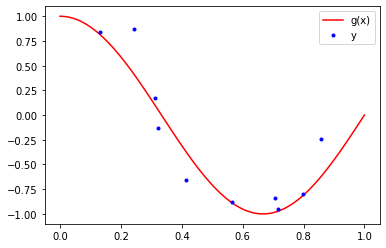

In [4]:
N_train = 10
N_test  = 100

# función verdadera g(x)
x = np.linspace(0,1,N_test)
g_x = np.cos(1.5*np.pi*x)

# proceso y
np.random.seed(0) # para asegurar reproducibilidad
epsilon = np.random.randn(N_test) * 0.2
y = g_x + epsilon

# Datos: D = {x_i,y_i}, obtenemos una muestra
idx = np.random.randint(0,N_test,N_train)
x_i = x[idx]
y_i = y[idx]

# dibujamos la función g(x), y el conjunto de datos x_i,y_i
plt.plot(x,g_x,'r',label='g(x)')
plt.plot(x_i,y_i,'b.',label='y')
plt.legend()
plt.show()

En primer lugar, ajustamos un modelo (regresión lineal) muy complejo sobre estos datos, de la forma:

$$f_{\omega}(x) = \omega_0 + \sum_{j=1}^{10}\omega_j x^j$$

el cual tiene 10 coeficientes ($\omega_1,\ldots,\omega_{10}$). Este modelo seguramente sufrirá de overfitting.

<div class = "alert alert-success">
EJERCICIO: Entrena un algoritmo de regresión lineal y calcula el error cuadrático medio del conjunto de test
</div>

Error cuadrático medio: $$MSE = \frac{1}{N}\sum_{i=1}^N \left(y^{(i)}-\hat{y}^{(i)}\right)^2$$

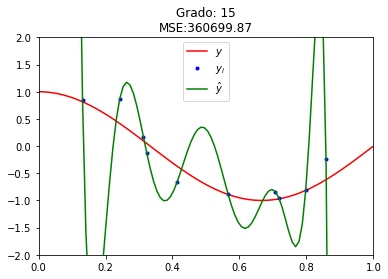

w0:  411.8507110539149
w1:  -0.0007470253913197666
w2:  -8668.035791088545
w3:  70464.55197743721
w4:  -280470.8378174515
w5:  546235.0637119833
w6:  -352911.06055769586
w7:  -312773.3489048091
w8:  270322.9436150285
w9:  374616.2547677995
w10:  -5705.244135623622
w11:  -343697.1244043536
w12:  -304475.8663389788
w13:  39737.28055798955
w14:  360990.11190769146
w15:  304112.36795521347

||w||_2^2 = 1.4e+12


In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 

degree = 15

# features
poly    = PolynomialFeatures(degree) # generamos x^j
X_train = poly.fit_transform(x_i.reshape(-1, 1))
y_train = y_i

X_test = poly.fit_transform(x.reshape(-1, 1))
y_test = y

# Entrena modelo: TU CÓDIGO AQUÍ
lr = LinearRegression().fit(X_train, y_train)
###

# predicción
y_hat = lr.predict(X_test)

# Calcula el MSE: TU CÓDIGO AQUÍ
mse = np.mean((y-y_hat)**2)
##

plt.plot(x,g_x,'r',label='$y$')
plt.plot(x_i,y_i,'b.',label='$y_i$')
plt.plot(x,y_hat,'g',label='$\hat{y}$')
plt.title('Grado: %i\nMSE:%.2f'%(degree,mse))
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

# Mostramos los coeficientes del modelo
print('w0: ', lr.intercept_)

w = lr.coef_
norm_w2 = np.dot(w,w.T) # no se tiene en cuenta el intercept

coef_names = ['w' + str(i) + ': ' for i in range(1,degree+1)]
for f,wi in zip(coef_names,w):
    print(f,wi)

print('\n||w||_2^2 = %.2g'%norm_w2)

## 2.1.1 Ridge regression

Se refiere al modelo de regresión lineal con penalización sobre la magnitud de los coeficientes

$$\min_{\boldsymbol{\omega}}|| \mathbf{y} - \mathbf{X}\boldsymbol{\omega}||_2^2 + \alpha ||\boldsymbol{\omega} ||_2^2$$

como medida contra el [*overfitting*](https://en.wikipedia.org/wiki/Overfitting)

El modelo de [*ridge regression*](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), tiene un parámetro libre ($\alpha$) que hemos de fijar a priori. En otras palabras, tenemos que dar un valor a $\alpha$ para que el modelo calcule los coeficientes $\boldsymbol{\omega}$. A tener en cuenta:

* Si $\alpha = 0$, entonces el resultado coincide con un modelo de [regresión lineal](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).
* Si $\alpha \to \infty$, entonces el valor de todos los coeficientes será nulo.

Por tanto, para buscar el valor de $\alpha$ adecuado, tendremos que barrer valores en una escala que cubra valores muy pequeños y valores elevados. Para ello, normalmente se utiliza escala logarítmica aumentando progresivamente el orden  de magnitud. Como ejemplo, podríamos barrer lambda utilizando los siguientes valores $\alpha = \{10^{-3},0.01,0.1,1,10,100,1000\}$, que en escala logarítmica queda como $\log_{10}({\alpha}) = \{-3,-2,-1,0,1,2,3\}$

Vamos a implementar el algoritmo de *ridge regression* variando los valores de $\alpha$, y viendo cómo esta variación afecta a los coeficientes $\boldsymbol{\omega}$ del modelo. 

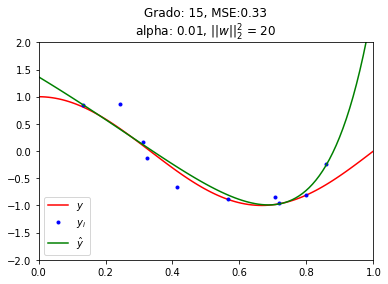

w1:  0.0
w2:  -3.720918346114223
w3:  -1.1902062955998238
w4:  0.4820756461933016
w5:  1.0596448997707097
w6:  1.0858713149041221
w7:  0.9171884773849934
w8:  0.7156067440768368
w9:  0.5395619435705429
w10:  0.4026304278963592
w11:  0.30186567191595903
w12:  0.22978087029594374
w13:  0.17885659380114194
w14:  0.14292318472340682
w15:  0.11734335212401091


In [6]:
from sklearn.linear_model import Ridge

#model
a = 1e-2 #parámetro alpha de regularización
ridge = Ridge(alpha=a).fit(X_train,y_train)
w = ridge.coef_
norm_w2 = np.dot(w,w.T)
    
# predicción
y_hat = ridge.predict(X_test)

# error
error_test = np.mean(np.power(y - y_hat,2)) 

plt.plot(x,g_x,'r',label='$y$')
plt.plot(x_i,y_i,'b.',label='$y_i$')
plt.plot(x,y_hat,'g',label='$\hat{y}$')
plt.title('Grado: %i, MSE:%.2f\nalpha: %g, $||w||_2^2$ = %.2g'%(degree,error_test,a,norm_w2))
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

coef_names = ['w' + str(i) + ': ' for i in range(1,degree+1)]

for f,wi in zip(coef_names,w):
    print(f,wi)

<div class = "alert alert-success">
EJERCICIO: Varía los valores de $\alpha$ y comprueba cómo afecta al resultado, ¿Cómo varían los coeficientes del modelo?
</div>

Representamos ahora el valor de los coeficientes del modelo y su norma para distintos valores del parámetro de regularización

<div class = "alert alert-success">
EJERCICIO: Entrene un modelo Ridge para distintos valores de $\alpha$
</div>

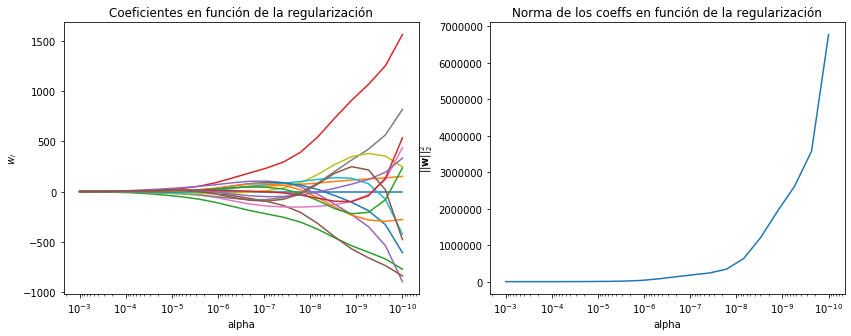

In [7]:
n_alphas = 20
alphas = np.logspace(-10, -3, n_alphas)

coefs = []

norm2_coefs = []
for a in alphas:
    #### TU CÓDIGO AQUÍ
    ridge = Ridge(alpha=a).fit(X_train,y_train)
    #####
    coefs.append(ridge.coef_)
    norm2_coefs.append(np.dot(ridge.coef_,ridge.coef_.T))

# Display results
plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()


<div class = "alert alert-success">
EJERCICIO: ¿Cuál es el valor óptimo de $\alpha$?
</div>

Para responder a este ejercicio de forma correcta debemos probar con distintos valores de $\alpha$ a partir de los datos, pero ¿cómo calculamos este valor? De nuevo, acudimos a la validación cruzada. 

best mean cross-validation score: -0.075
best parameters: {'alpha': 0.004641588833612773}


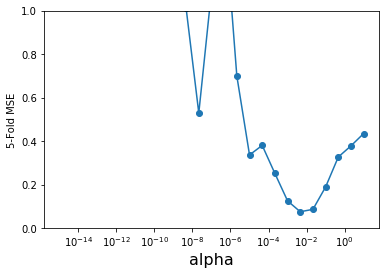

In [8]:
from sklearn.model_selection import GridSearchCV

# Por convención, GridSearchCV siempre intenta MAXIMIZAR los resultados, por lo que
# funciones de coste, como MSE, tienen que ir negadas: https://github.com/scikit-learn/scikit-learn/issues/2439
# Por eso aparece neg_mean_squared_error y por eso hay luego un -1 multiplicando

alpha_vector = np.logspace(-15,1,25)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Ridge(), scoring='neg_mean_squared_error', param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.ylim((0, 1))
plt.show()

<div class = "alert alert-success">
EJERCICIO: Descomente la línea plt.ylim((0, 1))
</div>

Entrenamos el modelo ahora con el valor óptimo de $\alpha$ que hemos encontrado con validación cruzada.

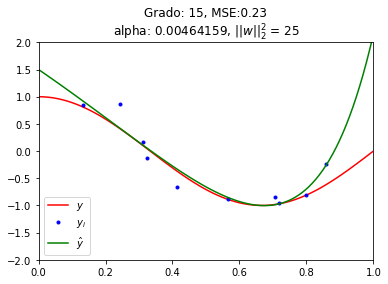

w1:  0.0
w2:  -4.226290800215783
w3:  -1.2171410265115368
w4:  0.8450250775305875
w5:  1.4440522715434074
w6:  1.3164688549523815
w7:  0.9747324506515234
w8:  0.6433395166470242
w9:  0.3905454374402415
w10:  0.22005079916567286
w11:  0.11517274475803413
w12:  0.056589423647800945
w13:  0.028161033875054045
w14:  0.018020496397464458
w15:  0.018056116920980973


In [9]:
alpha_optimo = grid.best_params_['alpha']
ridge = Ridge(alpha=alpha_optimo).fit(X_train,y_train)

# predicción
y_hat = ridge.predict(X_test)
w = ridge.coef_
norm_w2 = np.dot(w,w.T)

# error
error_test = np.mean(np.power(y - y_hat,2)) 


plt.plot(x,g_x,'r',label='$y$')
plt.plot(x_i,y_i,'b.',label='$y_i$')
plt.plot(x,y_hat,'g',label='$\hat{y}$')
plt.title('Grado: %i, MSE:%.2f\nalpha: %g, $||w||_2^2$ = %.2g'%(degree,error_test,alpha_optimo,norm_w2))
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

coef_names = ['w' + str(i) + ': ' for i in range(1,degree+1)]

for f,wi in zip(coef_names,w):
    print(f,wi)

## 2.1.2 Lasso 

Se refiere al modelo de regresión lineal con penalización (norma 1) sobre la magnitud de los coeficientes

$$\min_{\boldsymbol{\omega}}|| \mathbf{y} - \mathbf{X}\boldsymbol{\omega}||_2^2 + \alpha ||\boldsymbol{\omega} ||_1$$

donde $||\boldsymbol{\omega} ||_1 = |\omega_1| + |\omega_2| + \ldots + |\omega_D|$, siendo $D$ el número de atributos ($\omega_0$ no se tiene en cuenta en esta penalización).

Con esta formulación el algoritmo Lasso permite activar/desactivar coeficientes, de tal forma que se desactivan primero los coeficienes asociados a los atributos que menos influyen en la función de coste (función a minimizar anterior). Con ello:

1. Se previene el overfitting, al poder utilizar modelos con menos variables (las desactivamos)
2. Se gana interpretabilidad, al poder ver cómo evolucionan las variables supervivientes.

La activación y desactivación de variables está determinada por el parámetro de regularización $\alpha$, de la misma forma que sucede con el algoritmo Ridge:

* Si $\alpha = 0$, entonces el resultado coincide con un modelo de [regresión lineal](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).
* Si $\alpha \to \infty$, entonces el valor de todos los coeficientes será nulo.

<div class = "alert alert-success">
EJERCICIO: Repite los análisis anteriores (Ridge), para el algoritmo [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
</div>


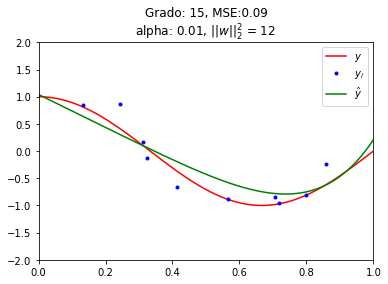

w1:  0.0
w2:  -3.0285798923794984
w3:  -0.0
w4:  0.0
w5:  0.0
w6:  0.8664928808279696
w7:  1.3300948828034658
w8:  0.0
w9:  0.0
w10:  0.0
w11:  0.0
w12:  0.0
w13:  0.0
w14:  0.0
w15:  0.0


In [10]:
from sklearn.linear_model import Lasso

#model
a = 1e-2 #parámetro alpha de regularización
lasso = Lasso(alpha=a).fit(X_train,y_train)
w = lasso.coef_
norm_w2 = np.dot(w,w.T)
    
# predicción
y_hat = lasso.predict(X_test)

# error
error_test = np.mean(np.power(y - y_hat,2)) 

plt.plot(x,g_x,'r',label='$y$')
plt.plot(x_i,y_i,'b.',label='$y_i$')
plt.plot(x,y_hat,'g',label='$\hat{y}$')
plt.title('Grado: %i, MSE:%.2f\nalpha: %g, $||w||_2^2$ = %.2g'%(degree,error_test,a,norm_w2))
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

coef_names = ['w' + str(i) + ': ' for i in range(1,degree+1)]

for f,wi in zip(coef_names,w):
    print(f,wi)

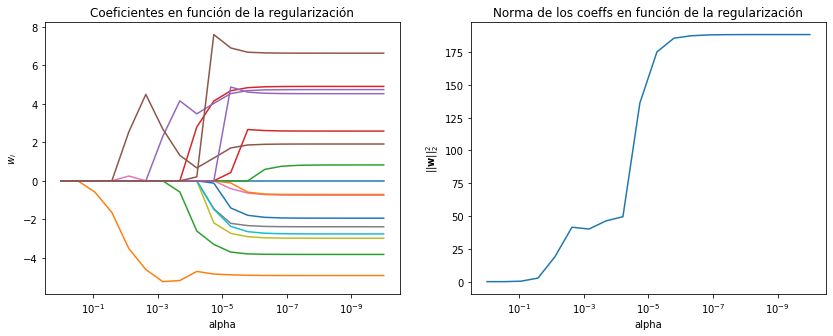

In [11]:
n_alphas = 20
alphas = np.logspace(-10, 0, n_alphas)

coefs = []

norm2_coefs = []
for a in alphas:
    #### TU CÓDIGO AQUÍ
    lasso = Lasso(alpha=a).fit(X_train,y_train)
    #####
    coefs.append(lasso.coef_)
    norm2_coefs.append(np.dot(lasso.coef_,lasso.coef_.T))

# Display results
plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()


best mean cross-validation score: -0.073
best parameters: {'alpha': 0.006189658188912597}


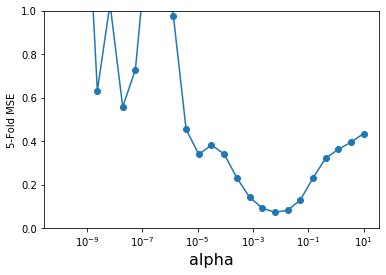

In [12]:
from sklearn.model_selection import GridSearchCV

# Por convención, GridSearchCV siempre intenta MAXIMIZAR los resultados, por lo que
# funciones de coste, como MSE, tienen que ir negadas: https://github.com/scikit-learn/scikit-learn/issues/2439
# Por eso aparece neg_mean_squared_error y por eso hay luego un -1 multiplicando

alpha_vector = np.logspace(-10,1,25)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Ridge(), scoring='neg_mean_squared_error', param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.ylim((0, 1))
plt.show()

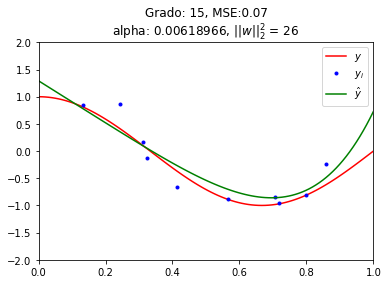

w1:  0.0
w2:  -3.8661904264973983
w3:  -0.0
w4:  0.0
w5:  0.0
w6:  3.3012494425850796
w7:  0.0
w8:  0.0
w9:  0.0
w10:  0.0
w11:  0.0
w12:  0.0
w13:  0.0
w14:  0.0
w15:  0.0


In [13]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha=alpha_optimo).fit(X_train,y_train)

# predicción
y_hat = lasso.predict(X_test)
w = lasso.coef_
norm_w2 = np.dot(w,w.T)

# error
error_test = np.mean(np.power(y - y_hat,2)) 


plt.plot(x,g_x,'r',label='$y$')
plt.plot(x_i,y_i,'b.',label='$y_i$')
plt.plot(x,y_hat,'g',label='$\hat{y}$')
plt.title('Grado: %i, MSE:%.2f\nalpha: %g, $||w||_2^2$ = %.2g'%(degree,error_test,alpha_optimo,norm_w2))
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

coef_names = ['w' + str(i) + ': ' for i in range(1,degree+1)]

for f,wi in zip(coef_names,w):
    print(f,wi)

<div class = "alert alert-success">
EJERCICIO: A la vista de los resultados, ¿qué diferencias entre Ridge y Lasso destacarías?
</div>

# 2.2 Regularización sobre algoritmos de clasificación

Algunos algoritmos de clasificación también tienen un parámetro que permite controlar su complejidad. En el caso de [regresión logística](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), la función de coste a minimizar es de la forma:

$$J(\boldsymbol{\omega}) = -\sum_{i=1}^N y^{(i)}\log{(\theta(\mathbf{x}^{(i)}))} + (1-y^{(i)})\log{\left(1-\theta(\mathbf{x}^{(i)})\right)}  = \sum_{i=1}^N \log{\left(1+ e^{-y^{(i)}\boldsymbol{\omega}^T\mathbf{x}^{(i)}}\right)}  $$

donde $\theta(\mathbf{x}^{(i)}) = \frac{1}{1+e^{-\boldsymbol{\omega}^T\mathbf{x}^{(i)}}}$. En su versión "regularizada", la función de coste pasa a ser:

$$J(\boldsymbol{\omega}) = \frac{1}{2}||\boldsymbol{\omega}||_2^2 + C \sum_{i=1}^N \log{\left(1+ e^{-y^{(i)}\boldsymbol{\omega}^T\mathbf{x}^{(i)}}\right)}$$

El **coste $C$** es el parámetro libre que permite controlar la complejidad del algoritmo, penalizando los errores que se cometen en clasificación. Este parámetro supone un compromiso entre la exactitud de la solución y la complejidad del algoritmo, en ese sentido es similar al parámetro de regularización $\alpha$ que utilizamos en Ridge y Lasso. En este caso, de forma intuitiva podemos decir que **$C$ se comporta como  $1/\alpha$**. Así:

- Cuanto mayor es $C$ (menor es $\alpha$), más penalizamos los errores en clasificación y la frontera se ajusta mucho a los datos (en el caso extremo se ajustará perfectamente). Riesgo de overfitting pero con potencial menor error de clasificación.


- Cuanto menor es $C$ (mayor es $\alpha$), menos penalizamos los errores en clasificación y tenderemos hacia modelos más sencillos (fronteras menos ajustadas, menor riesgo de overfitting pero potencialmente con más error de clasificación)

NOTA: por defecto, $C=1$ en scikit-learn.

# 2.2 Regularización sobre algoritmos de clasificación

Algunos algoritmos de clasificación también tienen un parámetro que permite controlar su complejidad. En el caso de [regresión logística](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), la función de coste a minimizar es de la forma:

$$J(\boldsymbol{\omega}) = -\sum_{i=1}^N y^{(i)}\log{(\theta(\mathbf{x}^{(i)}))} + (1-y^{(i)})\log{\left(1-\theta(\mathbf{x}^{(i)})\right)}  = \sum_{i=1}^N \log{\left(1+ e^{-y^{(i)}\boldsymbol{\omega}^T\mathbf{x}^{(i)}}\right)}  $$

donde $\theta(\mathbf{x}^{(i)}) = \frac{1}{1+e^{-\boldsymbol{\omega}^T\mathbf{x}^{(i)}}}$. En su versión "regularizada", la función de coste pasa a ser:

$$J(\boldsymbol{\omega}) = \frac{1}{2}||\boldsymbol{\omega}||_2^2 + C \sum_{i=1}^N \log{\left(1+ e^{-y^{(i)}\boldsymbol{\omega}^T\mathbf{x}^{(i)}}\right)}$$

El **coste $C$** es el parámetro libre que permite controlar la complejidad del algoritmo, penalizando los errores que se cometen en clasificación. Este parámetro supone un compromiso entre la exactitud de la solución y la complejidad del algoritmo, en ese sentido es similar al parámetro de regularización $\alpha$ que utilizamos en Ridge y Lasso. En este caso, de forma intuitiva podemos decir que **$C$ se comporta como  $1/\alpha$**. Así:

- Cuanto mayor es $C$ (menor es $\alpha$), más penalizamos los errores en clasificación y la frontera se ajusta mucho a los datos (en el caso extremo se ajustará perfectamente). Riesgo de overfitting pero con potencial menor error de clasificación.


- Cuanto menor es $C$ (mayor es $\alpha$), menos penalizamos los errores en clasificación y tenderemos hacia modelos más sencillos (fronteras menos ajustadas, menor riesgo de overfitting pero potencialmente con más error de clasificación)

NOTA: por defecto, $C=1$ en scikit-learn.

![](./figuras/Sesgo_varianza_parametros.png)



Veamos cómo funciona $C$ sobre los ejemplos de clasificación que hemos visto anteriormente.

In [14]:
# ejemplo1
ejemplo1 = pd.read_csv("./data/ex2data1.txt", sep=",", header=None, names=['x1', 'x2','label'])

# ejemplo2
ejemplo2 = pd.read_csv("./data/ex2data2.txt", sep=",", header=None, names=['x1', 'x2','label'])

# ejemplo 3: Problema XOR 
np.random.seed(0)

# -- parameters
N     = 800
mu    = 1.5      # Cambia este valor
sigma = 1      # Cambia este valor

# variables auxiliares
unos = np.ones(int(N/4))
random4 = sigma*np.random.randn(int(N/4),1)
random2 = sigma*np.random.randn(int(N/2),1)

# -- features
y3 = np.concatenate([-1*unos,       unos,          unos,         -1*unos]) 
X1 = np.concatenate([-mu + random4, mu + random4, -mu + random4, mu + random4])
X2 = np.concatenate([+mu + random2,               -mu + random2])
X3 = np.hstack((X1,X2))

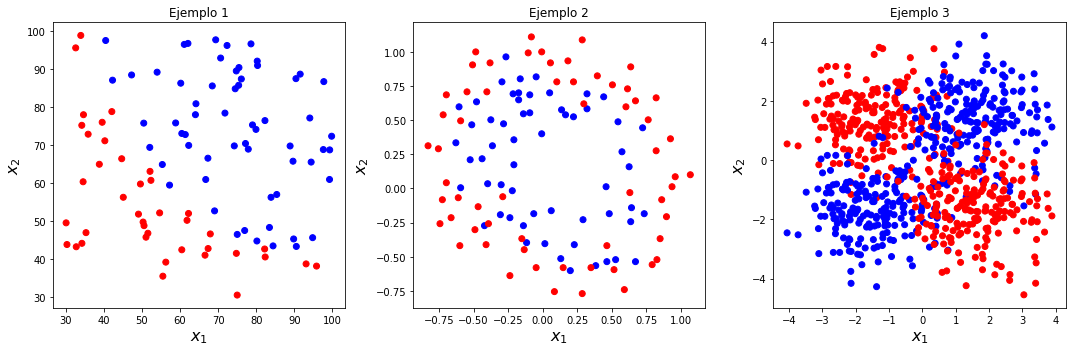

In [15]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(ejemplo1['x1'], ejemplo1['x2'], c=ejemplo1['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 1')

plt.subplot(1,3,2)
plt.scatter(ejemplo2['x1'], ejemplo2['x2'], c=ejemplo2['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 2')

plt.subplot(1,3,3)
plt.scatter(X3[:,0], X3[:,1], c=y3, cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 3')

plt.tight_layout()
plt.show()

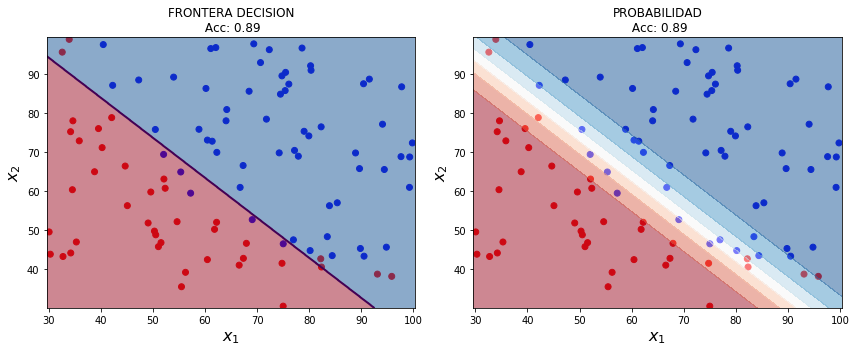

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# preparamos los datos
data1 = ejemplo1.values
X1 = data1[:,0:2]
y1 = data1[:,-1]

# creamos el modelo
lr1 = LogisticRegression()

# ajustamos con los datos disponibles
lr1.fit(X1,y1)
plot_decision_boundary(X1,y1,0.05,lr1)

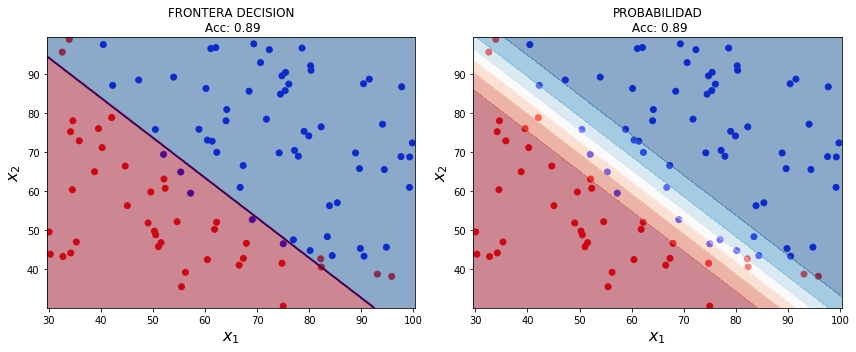

In [17]:
# C grande (ANTES DE EJECUTAR TRATA DE PENSAR CÓMO SERÁ EL RESULTADO!)
lr1 = LogisticRegression(C = 1000)
lr1.fit(X1,y1)
plot_decision_boundary(X1,y1,0.05,lr1)

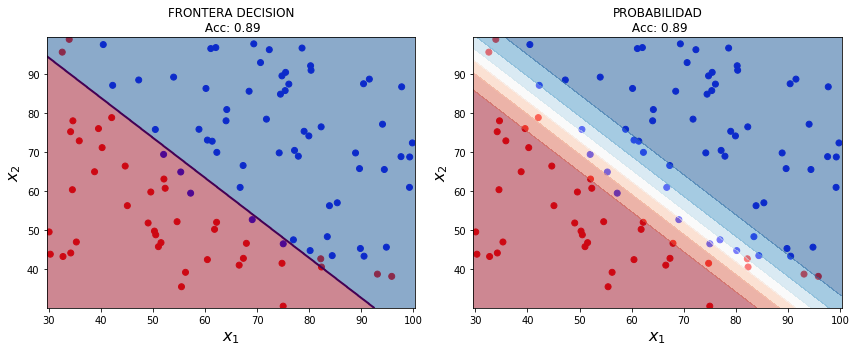

In [18]:
# C pequeño (ANTES DE EJECUTAR TRATA DE PENSAR CÓMO SERÁ EL RESULTADO!)
lr1 = LogisticRegression(C = 0.4)
lr1.fit(X1,y1)
plot_decision_boundary(X1,y1,0.05,lr1)

<div class = "alert alert-success">
EJERCICIO: Aplica el algoritmo de regresión logística sobre los ejemplos anteriores 2 y 3, variando el valor de $C$
</div>

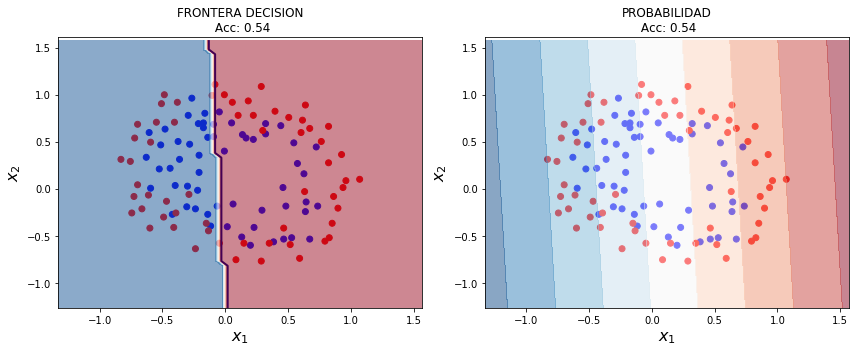

In [19]:
# Ejemplo 2
# preparamos los datos
data2 = ejemplo2.values
X2 = data2[:,0:2]
y2 = data2[:,-1]

# creamos el modelo
lr2 = LogisticRegression()

# ajustamos con los datos disponibles
lr2.fit(X2,y2)
plot_decision_boundary(X2,y2,0.05,lr2)

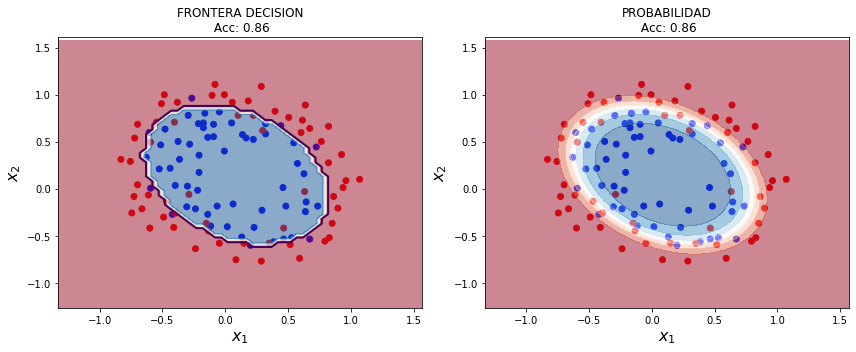

In [20]:
poly     = PolynomialFeatures()
X2poly   = poly.fit_transform(X2)

# creamos el modelo
lr_poly2 = LogisticRegression(C=100).fit(X2poly,y2)
plot_decision_boundary_poly(X2,y2,0.05,lr_poly2,poly)

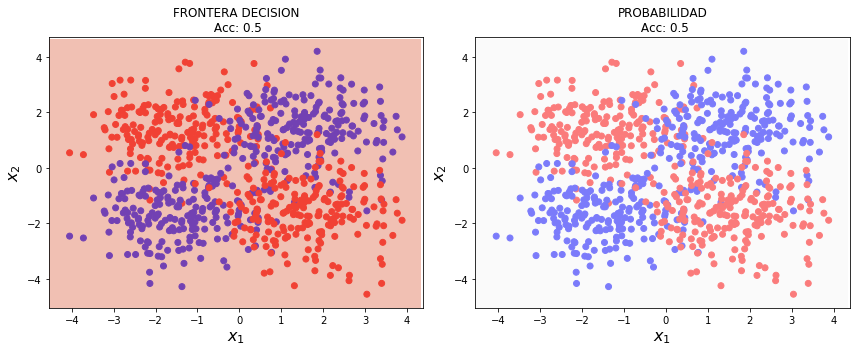

In [21]:
# Ejemplo 3
# creamos el modelo
lr3 = LogisticRegression()

# ajustamos con los datos disponibles
lr3.fit(X3,y3)
plot_decision_boundary(X3,y3,0.05,lr3)

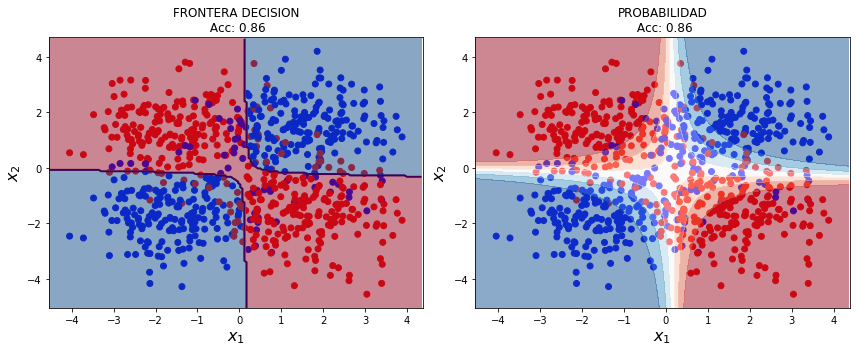

In [22]:
poly     = PolynomialFeatures()
X3poly   = poly.fit_transform(X3)

# creamos el modelo
lr_poly3 = LogisticRegression(C=1000).fit(X3poly,y3)
plot_decision_boundary_poly(X3,y3,0.05,lr_poly3,poly)

Pero cuidado, no hagamos trampas, ¿cómo tenemos que seleccionar el valor de $C$ adecuado para el problema?

<div class = "alert alert-success">
EJERCICIO: Calcula el valor óptimo de $C$ para el ejemplo 3
</div>

best mean cross-validation score: 0.871
best parameters: {'C': 0.00020691380811147902}
test-set score: 0.86


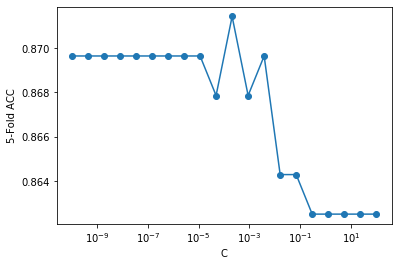

In [26]:
from sklearn.model_selection import train_test_split

poly     = PolynomialFeatures()
X3poly   = poly.fit_transform(X3)
X_train, X_test, y_train, y_test = train_test_split(X3poly, y3, test_size = 0.3, shuffle = True, random_state = 0)

vectorC = np.logspace(-10, 2, 20)
param_grid = {'C': vectorC}
grid = GridSearchCV(LogisticRegression(fit_intercept=False), scoring= 'accuracy', param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.2f}".format(grid.score(X_test, y_test)))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(vectorC,scores,'-o')
plt.xlabel('C')
plt.ylabel('5-Fold ACC')
#plt.ylim((0.868, 0.870))
plt.show()

<div class = "alert alert-success">
EJERCICIO: Representa la frontera de separación para el valor de $C$ óptimo
</div>

In [24]:
grid.best_params_

{'C': 0.00020691380811147902}

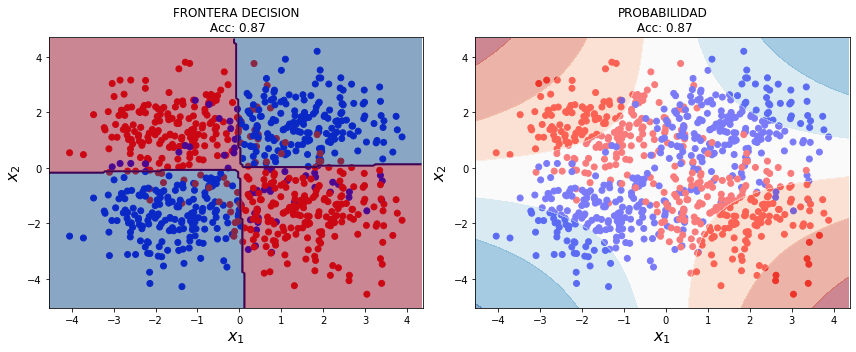

In [25]:
# Tu código aquí
Copt = grid.best_params_['C']
lr_poly3 = LogisticRegression(C=Copt, fit_intercept=False).fit(X_train,y_train)
plot_decision_boundary_poly(X3,y3,0.05,lr_poly3,poly)

A pesar de que la búsqueda de parámetros libres nos proporcione un valor óptimo, quizá éste está demasiado ajustado, por lo tanto es recomendable representar el resultado, en la medida de lo posible, e interpretarlo de forma correcta.

Casi todos los algoritmos de machine learning tienen un parámetro que controla la complejidad del mismo, y tenemos que conocer cómo afecta al resultado. Eso sí, para calcular su valor, siempre utilizaremos una estrategia adecuada de selección del modelo (normalmente validación cruzada). Y EL CONJUNTO DE TEST NO SE TOCA.